# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographical_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 11152 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.all)


  0% (    1 of 11152) |                   | Elapsed Time: 0:00:03 ETA:  11:08:55

  0% (   79 of 11152) |                    | Elapsed Time: 0:00:04 ETA:  0:02:27

  1% (  140 of 11152) |                    | Elapsed Time: 0:00:05 ETA:  0:02:07

  2% (  227 of 11152) |                    | Elapsed Time: 0:00:06 ETA:  0:02:04

  2% (  279 of 11152) |                    | Elapsed Time: 0:00:06 ETA:  0:01:58

  3% (  390 of 11152) |                    | Elapsed Time: 0:00:07 ETA:  0:01:50

  3% (  419 of 11152) |                    | Elapsed Time: 0:00:07 ETA:  0:01:49

  4% (  530 of 11152) |                    | Elapsed Time: 0:00:08 ETA:  0:01:44

  5% (  558 of 11152) |#                   | Elapsed Time: 0:00:09 ETA:  0:01:44

  5% (  646 of 11152) |#                   | Elapsed Time: 0:00:10 ETA:  0:01:45

  6% (  698 of 11152) |#                   | Elapsed Time: 0:00:10 ETA:  0:01:40

  7% (  787 of 11152) |#                   | Elapsed Time: 0:00:11 ETA:  0:01:41

  7% (  837 of 11152) |#                   | Elapsed Time: 0:00:12 ETA:  0:01:39

  8% (  932 of 11152) |#                   | Elapsed Time: 0:00:13 ETA:  0:01:40

  8% (  976 of 11152) |#                   | Elapsed Time: 0:00:13 ETA:  0:01:42

  9% ( 1079 of 11152) |#                   | Elapsed Time: 0:00:14 ETA:  0:01:40

 10% ( 1116 of 11152) |##                  | Elapsed Time: 0:00:15 ETA:  0:01:42

 10% ( 1198 of 11152) |##                  | Elapsed Time: 0:00:16 ETA:  0:01:44

 11% ( 1255 of 11152) |##                  | Elapsed Time: 0:00:16 ETA:  0:01:41

 11% ( 1311 of 11152) |##                  | Elapsed Time: 0:00:17 ETA:  0:01:47

 12% ( 1395 of 11152) |##                  | Elapsed Time: 0:00:18 ETA:  0:01:48

 13% ( 1492 of 11152) |##                  | Elapsed Time: 0:00:19 ETA:  0:01:46

 13% ( 1534 of 11152) |##                  | Elapsed Time: 0:00:20 ETA:  0:01:47

 14% ( 1631 of 11152) |##                  | Elapsed Time: 0:00:21 ETA:  0:01:45

 15% ( 1673 of 11152) |###                 | Elapsed Time: 0:00:21 ETA:  0:01:47

 15% ( 1783 of 11152) |###                 | Elapsed Time: 0:00:22 ETA:  0:01:43

 16% ( 1813 of 11152) |###                 | Elapsed Time: 0:00:23 ETA:  0:01:41

 17% ( 1925 of 11152) |###                 | Elapsed Time: 0:00:24 ETA:  0:01:37

 17% ( 1952 of 11152) |###                 | Elapsed Time: 0:00:24 ETA:  0:01:29

 18% ( 2036 of 11152) |###                 | Elapsed Time: 0:00:25 ETA:  0:01:28

 18% ( 2092 of 11152) |###                 | Elapsed Time: 0:00:25 ETA:  0:01:27

 19% ( 2198 of 11152) |###                 | Elapsed Time: 0:00:26 ETA:  0:01:24

 20% ( 2231 of 11152) |####                | Elapsed Time: 0:00:27 ETA:  0:01:23

 20% ( 2301 of 11152) |####                | Elapsed Time: 0:00:28 ETA:  0:01:27

 21% ( 2370 of 11152) |####                | Elapsed Time: 0:00:28 ETA:  0:01:30

 22% ( 2456 of 11152) |####                | Elapsed Time: 0:00:29 ETA:  0:01:30

 22% ( 2510 of 11152) |####                | Elapsed Time: 0:00:30 ETA:  0:01:32

 23% ( 2629 of 11152) |####                | Elapsed Time: 0:00:31 ETA:  0:01:27

 23% ( 2649 of 11152) |####                | Elapsed Time: 0:00:31 ETA:  0:01:25

 24% ( 2750 of 11152) |####                | Elapsed Time: 0:00:32 ETA:  0:01:24

 25% ( 2789 of 11152) |#####               | Elapsed Time: 0:00:33 ETA:  0:01:25

 25% ( 2859 of 11152) |#####               | Elapsed Time: 0:00:34 ETA:  0:01:29

 26% ( 2928 of 11152) |#####               | Elapsed Time: 0:00:35 ETA:  0:01:25

 27% ( 3028 of 11152) |#####               | Elapsed Time: 0:00:36 ETA:  0:01:23

 27% ( 3067 of 11152) |#####               | Elapsed Time: 0:00:36 ETA:  0:01:20

 28% ( 3169 of 11152) |#####               | Elapsed Time: 0:00:37 ETA:  0:01:18

 28% ( 3207 of 11152) |#####               | Elapsed Time: 0:00:37 ETA:  0:01:21

 29% ( 3294 of 11152) |#####               | Elapsed Time: 0:00:38 ETA:  0:01:21

 30% ( 3346 of 11152) |######              | Elapsed Time: 0:00:39 ETA:  0:01:22

 30% ( 3455 of 11152) |######              | Elapsed Time: 0:00:40 ETA:  0:01:19

 31% ( 3486 of 11152) |######              | Elapsed Time: 0:00:40 ETA:  0:01:14

 32% ( 3597 of 11152) |######              | Elapsed Time: 0:00:41 ETA:  0:01:08

 32% ( 3625 of 11152) |######              | Elapsed Time: 0:00:41 ETA:  0:01:08

 33% ( 3739 of 11152) |######              | Elapsed Time: 0:00:42 ETA:  0:01:05

 33% ( 3764 of 11152) |######              | Elapsed Time: 0:00:43 ETA:  0:01:05

 34% ( 3864 of 11152) |######              | Elapsed Time: 0:00:44 ETA:  0:01:05

 35% ( 3904 of 11152) |#######             | Elapsed Time: 0:00:44 ETA:  0:01:01

 35% ( 4008 of 11152) |#######             | Elapsed Time: 0:00:45 ETA:  0:00:58

 36% ( 4043 of 11152) |#######             | Elapsed Time: 0:00:45 ETA:  0:00:59

 37% ( 4148 of 11152) |#######             | Elapsed Time: 0:00:46 ETA:  0:00:58

 37% ( 4183 of 11152) |#######             | Elapsed Time: 0:00:47 ETA:  0:01:00

 38% ( 4286 of 11152) |#######             | Elapsed Time: 0:00:48 ETA:  0:00:59

 38% ( 4322 of 11152) |#######             | Elapsed Time: 0:00:48 ETA:  0:01:01

 39% ( 4427 of 11152) |#######             | Elapsed Time: 0:00:49 ETA:  0:00:59

 40% ( 4461 of 11152) |########            | Elapsed Time: 0:00:49 ETA:  0:00:58

 41% ( 4574 of 11152) |########            | Elapsed Time: 0:00:50 ETA:  0:00:56

 41% ( 4601 of 11152) |########            | Elapsed Time: 0:00:51 ETA:  0:00:56

 42% ( 4701 of 11152) |########            | Elapsed Time: 0:00:52 ETA:  0:00:55

 42% ( 4740 of 11152) |########            | Elapsed Time: 0:00:52 ETA:  0:00:54

 43% ( 4858 of 11152) |########            | Elapsed Time: 0:00:53 ETA:  0:00:51

 43% ( 4880 of 11152) |########            | Elapsed Time: 0:00:53 ETA:  0:00:49

 44% ( 4981 of 11152) |########            | Elapsed Time: 0:00:54 ETA:  0:00:49

 45% ( 5019 of 11152) |#########           | Elapsed Time: 0:00:55 ETA:  0:00:48

 45% ( 5118 of 11152) |#########           | Elapsed Time: 0:00:56 ETA:  0:00:48

 46% ( 5158 of 11152) |#########           | Elapsed Time: 0:00:56 ETA:  0:00:51

 46% ( 5219 of 11152) |#########           | Elapsed Time: 0:00:57 ETA:  0:00:57

 47% ( 5298 of 11152) |#########           | Elapsed Time: 0:00:58 ETA:  0:00:58

 48% ( 5399 of 11152) |#########           | Elapsed Time: 0:00:59 ETA:  0:00:57

 48% ( 5437 of 11152) |#########           | Elapsed Time: 0:00:59 ETA:  0:01:01

 49% ( 5537 of 11152) |#########           | Elapsed Time: 0:01:00 ETA:  0:00:59

 50% ( 5577 of 11152) |##########          | Elapsed Time: 0:01:01 ETA:  0:01:00

 50% ( 5684 of 11152) |##########          | Elapsed Time: 0:01:02 ETA:  0:00:58

 51% ( 5716 of 11152) |##########          | Elapsed Time: 0:01:02 ETA:  0:00:58

 52% ( 5826 of 11152) |##########          | Elapsed Time: 0:01:03 ETA:  0:00:53

 52% ( 5855 of 11152) |##########          | Elapsed Time: 0:01:03 ETA:  0:00:46

 53% ( 5959 of 11152) |##########          | Elapsed Time: 0:01:04 ETA:  0:00:43

 53% ( 5995 of 11152) |##########          | Elapsed Time: 0:01:05 ETA:  0:00:43

 54% ( 6105 of 11152) |##########          | Elapsed Time: 0:01:06 ETA:  0:00:41

 55% ( 6134 of 11152) |###########         | Elapsed Time: 0:01:06 ETA:  0:00:40

 55% ( 6234 of 11152) |###########         | Elapsed Time: 0:01:07 ETA:  0:00:39

 56% ( 6274 of 11152) |###########         | Elapsed Time: 0:01:08 ETA:  0:00:40

 57% ( 6382 of 11152) |###########         | Elapsed Time: 0:01:09 ETA:  0:00:39

 57% ( 6413 of 11152) |###########         | Elapsed Time: 0:01:09 ETA:  0:00:40

 58% ( 6521 of 11152) |###########         | Elapsed Time: 0:01:10 ETA:  0:00:38

 58% ( 6552 of 11152) |###########         | Elapsed Time: 0:01:10 ETA:  0:00:38

 59% ( 6634 of 11152) |###########         | Elapsed Time: 0:01:11 ETA:  0:00:40

 60% ( 6692 of 11152) |############        | Elapsed Time: 0:01:12 ETA:  0:00:42

 61% ( 6803 of 11152) |############        | Elapsed Time: 0:01:13 ETA:  0:00:38

 61% ( 6831 of 11152) |############        | Elapsed Time: 0:01:13 ETA:  0:00:39

 62% ( 6933 of 11152) |############        | Elapsed Time: 0:01:14 ETA:  0:00:37

 62% ( 6971 of 11152) |############        | Elapsed Time: 0:01:15 ETA:  0:00:39

 63% ( 7074 of 11152) |############        | Elapsed Time: 0:01:16 ETA:  0:00:37

 63% ( 7110 of 11152) |############        | Elapsed Time: 0:01:16 ETA:  0:00:38

 64% ( 7205 of 11152) |############        | Elapsed Time: 0:01:17 ETA:  0:00:38

 65% ( 7249 of 11152) |#############       | Elapsed Time: 0:01:17 ETA:  0:00:34

 65% ( 7352 of 11152) |#############       | Elapsed Time: 0:01:18 ETA:  0:00:31

 66% ( 7389 of 11152) |#############       | Elapsed Time: 0:01:19 ETA:  0:00:32

 67% ( 7496 of 11152) |#############       | Elapsed Time: 0:01:20 ETA:  0:00:29

 67% ( 7528 of 11152) |#############       | Elapsed Time: 0:01:20 ETA:  0:00:28

 68% ( 7624 of 11152) |#############       | Elapsed Time: 0:01:21 ETA:  0:00:27

 68% ( 7668 of 11152) |#############       | Elapsed Time: 0:01:22 ETA:  0:00:28

 69% ( 7751 of 11152) |#############       | Elapsed Time: 0:01:23 ETA:  0:00:31

 70% ( 7807 of 11152) |##############      | Elapsed Time: 0:01:23 ETA:  0:00:29

 70% ( 7904 of 11152) |##############      | Elapsed Time: 0:01:24 ETA:  0:00:29

 71% ( 7946 of 11152) |##############      | Elapsed Time: 0:01:25 ETA:  0:00:30

 72% ( 8046 of 11152) |##############      | Elapsed Time: 0:01:26 ETA:  0:00:29

 72% ( 8086 of 11152) |##############      | Elapsed Time: 0:01:27 ETA:  0:00:44

 73% ( 8176 of 11152) |##############      | Elapsed Time: 0:01:28 ETA:  0:00:44

 73% ( 8225 of 11152) |##############      | Elapsed Time: 0:01:28 ETA:  0:00:43

 74% ( 8310 of 11152) |##############      | Elapsed Time: 0:01:29 ETA:  0:00:41

 75% ( 8365 of 11152) |###############     | Elapsed Time: 0:01:30 ETA:  0:00:41

 75% ( 8470 of 11152) |###############     | Elapsed Time: 0:01:31 ETA:  0:00:38

 76% ( 8504 of 11152) |###############     | Elapsed Time: 0:01:31 ETA:  0:00:38

 77% ( 8643 of 11152) |###############     | Elapsed Time: 0:01:32 ETA:  0:00:20

 78% ( 8740 of 11152) |###############     | Elapsed Time: 0:01:33 ETA:  0:00:19

 78% ( 8783 of 11152) |###############     | Elapsed Time: 0:01:34 ETA:  0:00:16

 79% ( 8892 of 11152) |###############     | Elapsed Time: 0:01:35 ETA:  0:00:13

 80% ( 8922 of 11152) |################    | Elapsed Time: 0:01:35 ETA:  0:00:09

 80% ( 9017 of 11152) |################    | Elapsed Time: 0:01:36 ETA:  0:00:09

 81% ( 9062 of 11152) |################    | Elapsed Time: 0:01:36 ETA:  0:00:08

 82% ( 9165 of 11152) |################    | Elapsed Time: 0:01:37 ETA:  0:00:07

 82% ( 9201 of 11152) |################    | Elapsed Time: 0:01:38 ETA:  0:00:10

 83% ( 9296 of 11152) |################    | Elapsed Time: 0:01:39 ETA:  0:00:11

 83% ( 9340 of 11152) |################    | Elapsed Time: 0:01:39 ETA:  0:00:09

 84% ( 9448 of 11152) |################    | Elapsed Time: 0:01:40 ETA:  0:00:08

 85% ( 9480 of 11152) |#################   | Elapsed Time: 0:01:41 ETA:  0:00:10

 85% ( 9577 of 11152) |#################   | Elapsed Time: 0:01:42 ETA:  0:00:10

 86% ( 9619 of 11152) |#################   | Elapsed Time: 0:01:42 ETA:  0:00:08

 87% ( 9722 of 11152) |#################   | Elapsed Time: 0:01:43 ETA:  0:00:08

 87% ( 9759 of 11152) |#################   | Elapsed Time: 0:01:43 ETA:  0:00:07

 88% ( 9864 of 11152) |#################   | Elapsed Time: 0:01:44 ETA:  0:00:05

 88% ( 9898 of 11152) |#################   | Elapsed Time: 0:01:45 ETA:  0:00:03

 89% ( 9994 of 11152) |#################   | Elapsed Time: 0:01:46 ETA:  0:00:03

 90% (10037 of 11152) |##################  | Elapsed Time: 0:01:46 ETA:  0:00:04

 90% (10147 of 11152) |##################  | Elapsed Time: 0:01:47 ETA:  0:00:01

 91% (10177 of 11152) |##################  | Elapsed Time: 0:01:47 ETA:  0:00:00

 92% (10271 of 11152) |##################  | Elapsed Time: 0:01:48 ETA:  0:00:01

 92% (10316 of 11152) |##################  | Elapsed Time: 0:01:49 ETA:  0:00:02

 93% (10414 of 11152) |##################  | Elapsed Time: 0:01:50 ETA:  0:00:02

 93% (10456 of 11152) |##################  | Elapsed Time: 0:01:50 ETA:  0:00:04

 94% (10543 of 11152) |##################  | Elapsed Time: 0:01:51 ETA:  0:00:06

 95% (10595 of 11152) |################### | Elapsed Time: 0:01:52 ETA:  0:00:04

 95% (10688 of 11152) |################### | Elapsed Time: 0:01:53 ETA:  0:00:04

 96% (10734 of 11152) |################### | Elapsed Time: 0:01:53 ETA:  0:00:06

 97% (10838 of 11152) |################### | Elapsed Time: 0:01:54 ETA:  0:00:03

 97% (10874 of 11152) |################### | Elapsed Time: 0:01:55 ETA:  0:00:01

 98% (10974 of 11152) |################### | Elapsed Time: 0:01:56 ETA:  0:00:00

 98% (11013 of 11152) |################### | Elapsed Time: 0:01:56 ETA:  0:00:00

 99% (11105 of 11152) |################### | Elapsed Time: 0:01:57 ETA:  0:00:00

100% (11152 of 11152) |####################| Elapsed Time: 0:01:58 Time: 0:01:58


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

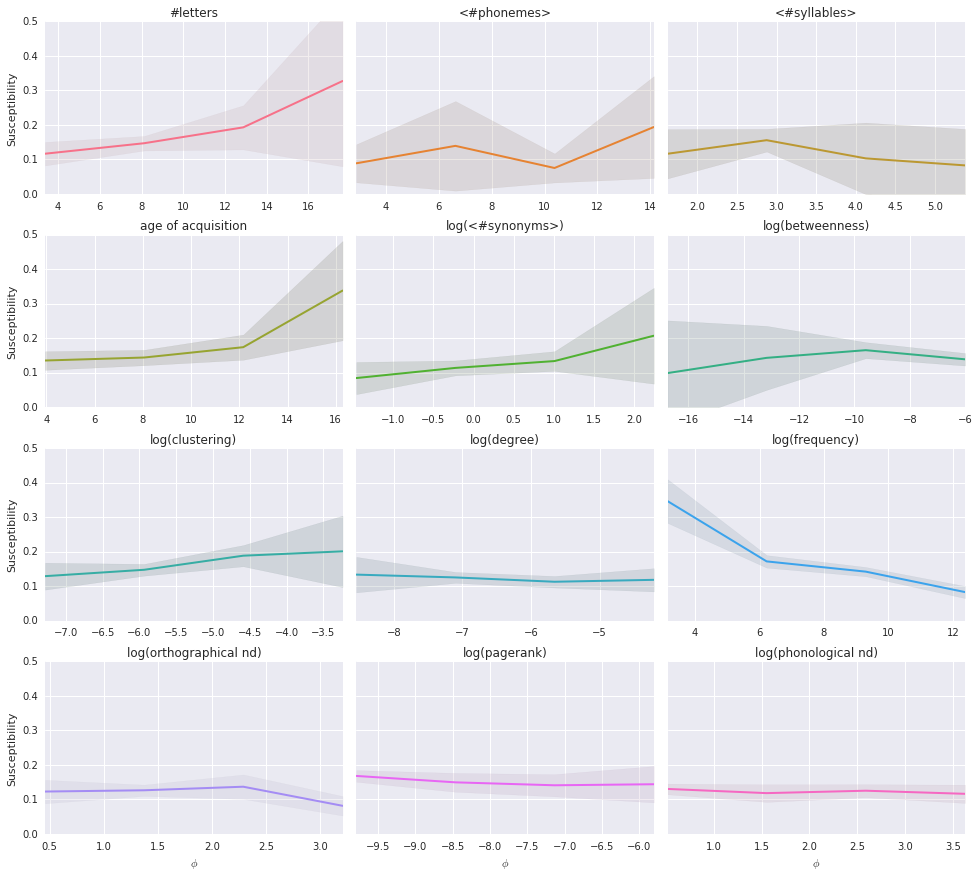

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

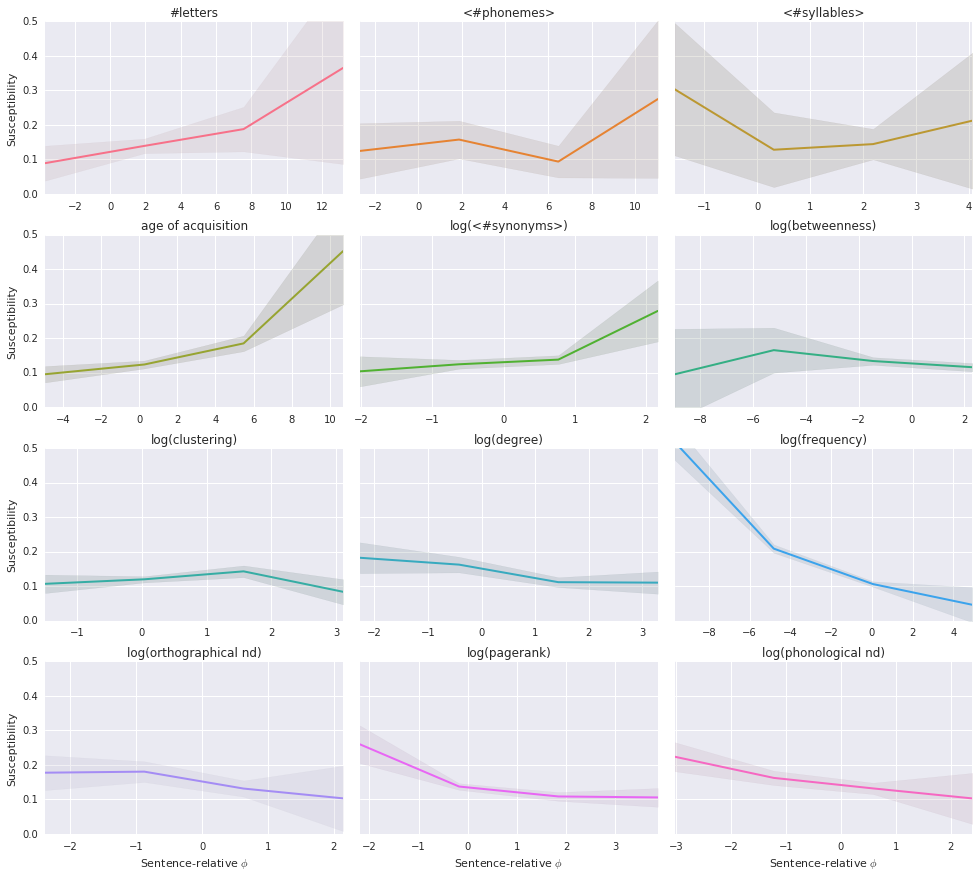

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

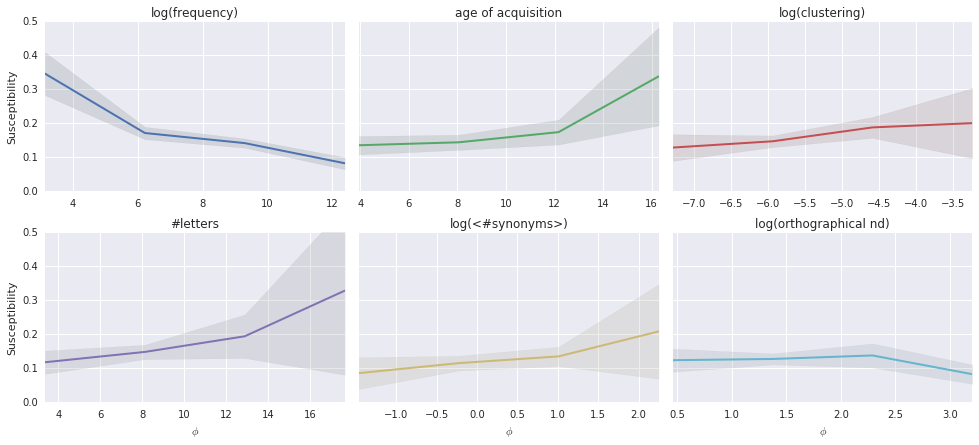

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

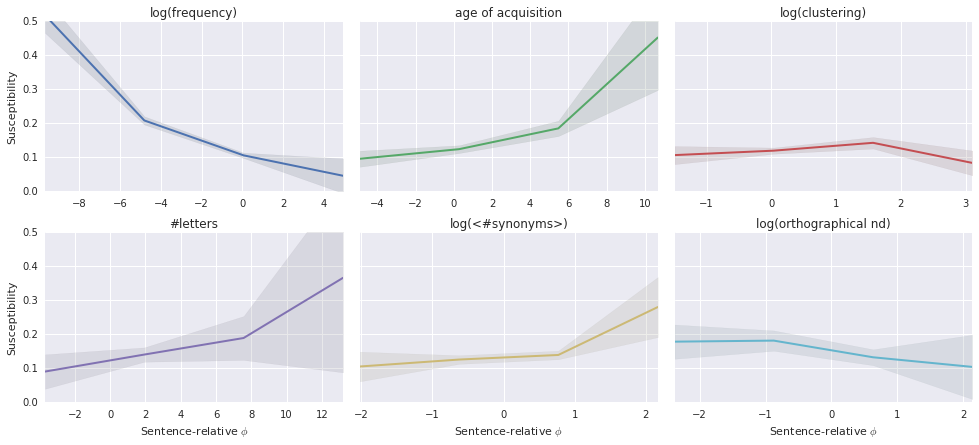

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

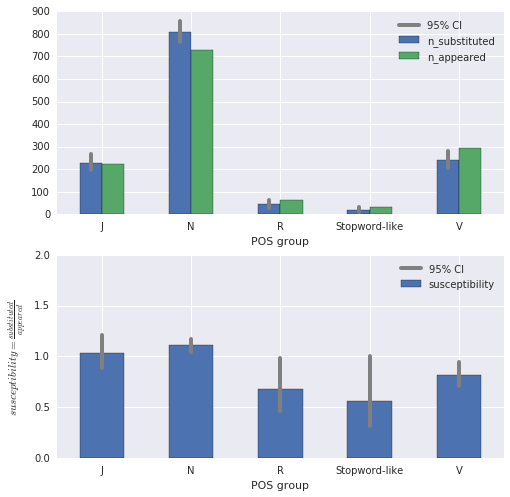

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like', 'V']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

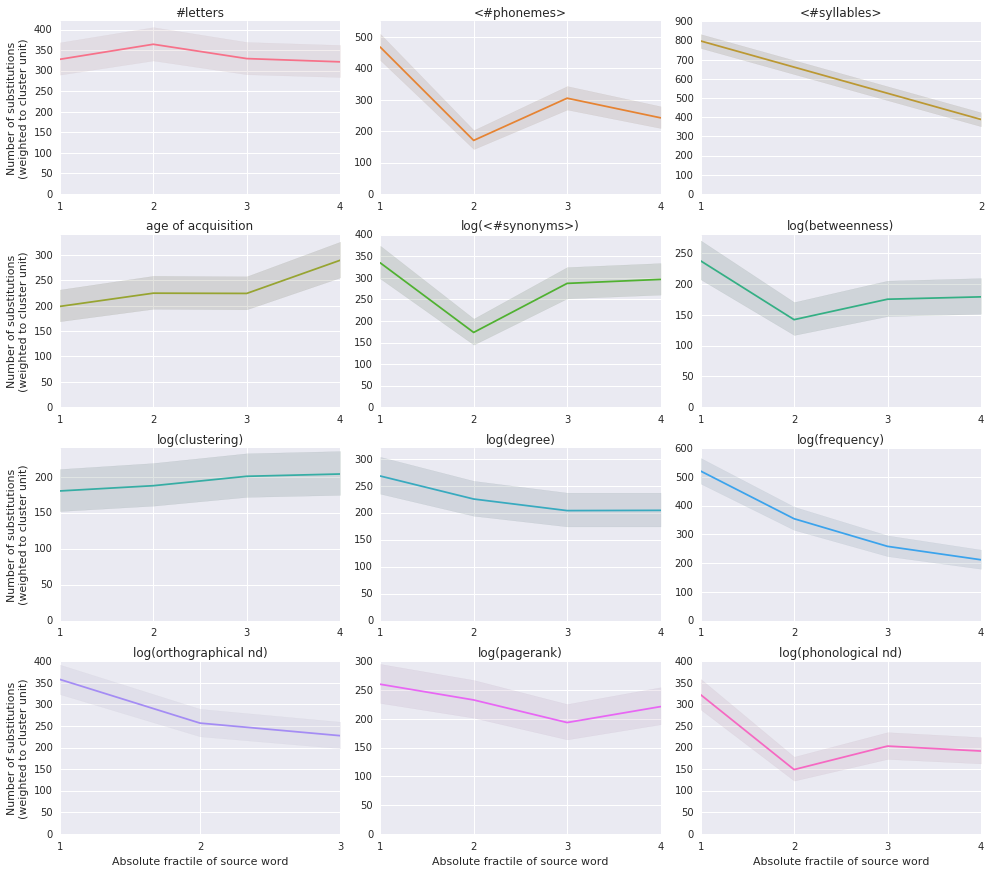

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

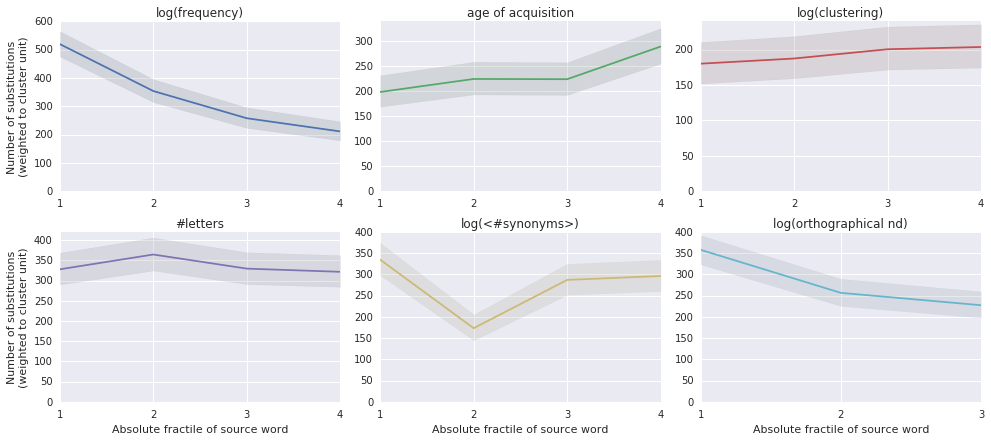

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (   92 of 11152) |                    | Elapsed Time: 0:00:01 ETA:  0:02:00

  1% (  140 of 11152) |                    | Elapsed Time: 0:00:01 ETA:  0:01:26

  2% (  233 of 11152) |                    | Elapsed Time: 0:00:02 ETA:  0:01:46

  2% (  279 of 11152) |                    | Elapsed Time: 0:00:02 ETA:  0:01:45

  3% (  385 of 11152) |                    | Elapsed Time: 0:00:03 ETA:  0:01:43

  3% (  419 of 11152) |                    | Elapsed Time: 0:00:04 ETA:  0:01:43

  4% (  517 of 11152) |                    | Elapsed Time: 0:00:05 ETA:  0:01:43

  5% (  558 of 11152) |#                   | Elapsed Time: 0:00:05 ETA:  0:01:43

  5% (  651 of 11152) |#                   | Elapsed Time: 0:00:06 ETA:  0:01:44

  6% (  698 of 11152) |#                   | Elapsed Time: 0:00:07 ETA:  0:01:43

  6% (  776 of 11152) |#                   | Elapsed Time: 0:00:08 ETA:  0:01:48

  7% (  837 of 11152) |#                   | Elapsed Time: 0:00:08 ETA:  0:01:46

  8% (  943 of 11152) |#                   | Elapsed Time: 0:00:09 ETA:  0:01:44

  8% (  976 of 11152) |#                   | Elapsed Time: 0:00:10 ETA:  0:01:46

  9% ( 1072 of 11152) |#                   | Elapsed Time: 0:00:11 ETA:  0:01:46

 10% ( 1116 of 11152) |##                  | Elapsed Time: 0:00:11 ETA:  0:01:45

 10% ( 1188 of 11152) |##                  | Elapsed Time: 0:00:12 ETA:  0:01:49

 11% ( 1255 of 11152) |##                  | Elapsed Time: 0:00:13 ETA:  0:01:48

 12% ( 1345 of 11152) |##                  | Elapsed Time: 0:00:14 ETA:  0:01:49

 12% ( 1395 of 11152) |##                  | Elapsed Time: 0:00:14 ETA:  0:01:46

 13% ( 1485 of 11152) |##                  | Elapsed Time: 0:00:15 ETA:  0:01:47

 13% ( 1534 of 11152) |##                  | Elapsed Time: 0:00:16 ETA:  0:01:48

 14% ( 1623 of 11152) |##                  | Elapsed Time: 0:00:17 ETA:  0:01:47

 15% ( 1673 of 11152) |###                 | Elapsed Time: 0:00:17 ETA:  0:01:46

 15% ( 1775 of 11152) |###                 | Elapsed Time: 0:00:18 ETA:  0:01:44

 16% ( 1813 of 11152) |###                 | Elapsed Time: 0:00:19 ETA:  0:01:39

 17% ( 1901 of 11152) |###                 | Elapsed Time: 0:00:20 ETA:  0:01:39

 17% ( 1952 of 11152) |###                 | Elapsed Time: 0:00:20 ETA:  0:01:39

 18% ( 2048 of 11152) |###                 | Elapsed Time: 0:00:21 ETA:  0:01:36

 18% ( 2092 of 11152) |###                 | Elapsed Time: 0:00:22 ETA:  0:01:35

 19% ( 2183 of 11152) |###                 | Elapsed Time: 0:00:23 ETA:  0:01:36

 20% ( 2231 of 11152) |####                | Elapsed Time: 0:00:23 ETA:  0:01:36

 20% ( 2310 of 11152) |####                | Elapsed Time: 0:00:24 ETA:  0:01:39

 21% ( 2370 of 11152) |####                | Elapsed Time: 0:00:25 ETA:  0:01:41

 22% ( 2461 of 11152) |####                | Elapsed Time: 0:00:26 ETA:  0:01:41

 22% ( 2510 of 11152) |####                | Elapsed Time: 0:00:27 ETA:  0:01:41

 23% ( 2594 of 11152) |####                | Elapsed Time: 0:00:28 ETA:  0:01:40

 23% ( 2649 of 11152) |####                | Elapsed Time: 0:00:28 ETA:  0:01:41

 24% ( 2755 of 11152) |####                | Elapsed Time: 0:00:29 ETA:  0:01:37

 25% ( 2789 of 11152) |#####               | Elapsed Time: 0:00:30 ETA:  0:01:35

 25% ( 2887 of 11152) |#####               | Elapsed Time: 0:00:31 ETA:  0:01:32

 26% ( 2928 of 11152) |#####               | Elapsed Time: 0:00:31 ETA:  0:01:27

 27% ( 3038 of 11152) |#####               | Elapsed Time: 0:00:32 ETA:  0:01:22

 27% ( 3067 of 11152) |#####               | Elapsed Time: 0:00:32 ETA:  0:01:21

 28% ( 3154 of 11152) |#####               | Elapsed Time: 0:00:33 ETA:  0:01:20

 28% ( 3207 of 11152) |#####               | Elapsed Time: 0:00:34 ETA:  0:01:17

 30% ( 3346 of 11152) |######              | Elapsed Time: 0:00:35 ETA:  0:01:10

 30% ( 3452 of 11152) |######              | Elapsed Time: 0:00:36 ETA:  0:01:09

 31% ( 3486 of 11152) |######              | Elapsed Time: 0:00:36 ETA:  0:01:09

 32% ( 3586 of 11152) |######              | Elapsed Time: 0:00:37 ETA:  0:01:09

 32% ( 3625 of 11152) |######              | Elapsed Time: 0:00:38 ETA:  0:01:10

 33% ( 3726 of 11152) |######              | Elapsed Time: 0:00:39 ETA:  0:01:09

 33% ( 3764 of 11152) |######              | Elapsed Time: 0:00:39 ETA:  0:01:07

 34% ( 3846 of 11152) |######              | Elapsed Time: 0:00:40 ETA:  0:01:09

 35% ( 3904 of 11152) |#######             | Elapsed Time: 0:00:41 ETA:  0:01:15

 35% ( 4001 of 11152) |#######             | Elapsed Time: 0:00:42 ETA:  0:01:14

 36% ( 4043 of 11152) |#######             | Elapsed Time: 0:00:43 ETA:  0:01:31

 37% ( 4139 of 11152) |#######             | Elapsed Time: 0:00:44 ETA:  0:01:31

 37% ( 4183 of 11152) |#######             | Elapsed Time: 0:00:44 ETA:  0:01:31

 38% ( 4274 of 11152) |#######             | Elapsed Time: 0:00:45 ETA:  0:01:32

 38% ( 4322 of 11152) |#######             | Elapsed Time: 0:00:46 ETA:  0:01:33

 39% ( 4430 of 11152) |#######             | Elapsed Time: 0:00:47 ETA:  0:01:25

 40% ( 4461 of 11152) |########            | Elapsed Time: 0:00:47 ETA:  0:01:25

 40% ( 4551 of 11152) |########            | Elapsed Time: 0:00:48 ETA:  0:01:26

 41% ( 4601 of 11152) |########            | Elapsed Time: 0:00:49 ETA:  0:01:08

 41% ( 4680 of 11152) |########            | Elapsed Time: 0:00:50 ETA:  0:01:10

 42% ( 4740 of 11152) |########            | Elapsed Time: 0:00:50 ETA:  0:01:09

 43% ( 4842 of 11152) |########            | Elapsed Time: 0:00:51 ETA:  0:01:07

 43% ( 4880 of 11152) |########            | Elapsed Time: 0:00:52 ETA:  0:01:06

 44% ( 4973 of 11152) |########            | Elapsed Time: 0:00:53 ETA:  0:01:04

 45% ( 5019 of 11152) |#########           | Elapsed Time: 0:00:53 ETA:  0:01:05

 45% ( 5124 of 11152) |#########           | Elapsed Time: 0:00:54 ETA:  0:01:02

 46% ( 5158 of 11152) |#########           | Elapsed Time: 0:00:55 ETA:  0:01:00

 47% ( 5257 of 11152) |#########           | Elapsed Time: 0:00:56 ETA:  0:00:58

 47% ( 5298 of 11152) |#########           | Elapsed Time: 0:00:56 ETA:  0:00:55

 48% ( 5398 of 11152) |#########           | Elapsed Time: 0:00:57 ETA:  0:00:55

 48% ( 5437 of 11152) |#########           | Elapsed Time: 0:00:58 ETA:  0:00:55

 49% ( 5541 of 11152) |#########           | Elapsed Time: 0:00:59 ETA:  0:00:53

 50% ( 5577 of 11152) |##########          | Elapsed Time: 0:00:59 ETA:  0:00:52

 50% ( 5677 of 11152) |##########          | Elapsed Time: 0:01:00 ETA:  0:00:52

 51% ( 5716 of 11152) |##########          | Elapsed Time: 0:01:00 ETA:  0:00:52

 52% ( 5810 of 11152) |##########          | Elapsed Time: 0:01:01 ETA:  0:00:52

 52% ( 5855 of 11152) |##########          | Elapsed Time: 0:01:02 ETA:  0:00:53

 53% ( 5953 of 11152) |##########          | Elapsed Time: 0:01:03 ETA:  0:00:51

 53% ( 5995 of 11152) |##########          | Elapsed Time: 0:01:03 ETA:  0:00:51

 55% ( 6134 of 11152) |###########         | Elapsed Time: 0:01:04 ETA:  0:00:46

 56% ( 6247 of 11152) |###########         | Elapsed Time: 0:01:05 ETA:  0:00:42

 56% ( 6274 of 11152) |###########         | Elapsed Time: 0:01:06 ETA:  0:00:42

 57% ( 6413 of 11152) |###########         | Elapsed Time: 0:01:07 ETA:  0:00:33

 58% ( 6509 of 11152) |###########         | Elapsed Time: 0:01:08 ETA:  0:00:33

 58% ( 6552 of 11152) |###########         | Elapsed Time: 0:01:08 ETA:  0:00:31

 59% ( 6667 of 11152) |###########         | Elapsed Time: 0:01:09 ETA:  0:00:29

 60% ( 6692 of 11152) |############        | Elapsed Time: 0:01:10 ETA:  0:00:30

 60% ( 6786 of 11152) |############        | Elapsed Time: 0:01:11 ETA:  0:00:32

 61% ( 6831 of 11152) |############        | Elapsed Time: 0:01:11 ETA:  0:00:34

 62% ( 6930 of 11152) |############        | Elapsed Time: 0:01:12 ETA:  0:00:33

 62% ( 6971 of 11152) |############        | Elapsed Time: 0:01:12 ETA:  0:00:39

 63% ( 7067 of 11152) |############        | Elapsed Time: 0:01:13 ETA:  0:00:39

 63% ( 7110 of 11152) |############        | Elapsed Time: 0:01:14 ETA:  0:00:38

 64% ( 7210 of 11152) |############        | Elapsed Time: 0:01:15 ETA:  0:00:37

 65% ( 7249 of 11152) |#############       | Elapsed Time: 0:01:15 ETA:  0:00:38

 66% ( 7389 of 11152) |#############       | Elapsed Time: 0:01:16 ETA:  0:00:31

 67% ( 7528 of 11152) |#############       | Elapsed Time: 0:01:17 ETA:  0:00:22

 68% ( 7644 of 11152) |#############       | Elapsed Time: 0:01:18 ETA:  0:00:19

 68% ( 7668 of 11152) |#############       | Elapsed Time: 0:01:19 ETA:  0:00:19

 69% ( 7764 of 11152) |#############       | Elapsed Time: 0:01:20 ETA:  0:00:18

 70% ( 7807 of 11152) |##############      | Elapsed Time: 0:01:20 ETA:  0:00:17

 70% ( 7916 of 11152) |##############      | Elapsed Time: 0:01:21 ETA:  0:00:15

 71% ( 7946 of 11152) |##############      | Elapsed Time: 0:01:21 ETA:  0:00:16

 72% ( 8086 of 11152) |##############      | Elapsed Time: 0:01:23 ETA:  0:00:15

 73% ( 8188 of 11152) |##############      | Elapsed Time: 0:01:24 ETA:  0:00:22

 73% ( 8225 of 11152) |##############      | Elapsed Time: 0:01:24 ETA:  0:00:23

 74% ( 8311 of 11152) |##############      | Elapsed Time: 0:01:25 ETA:  0:00:24

 75% ( 8365 of 11152) |###############     | Elapsed Time: 0:01:25 ETA:  0:00:22

 75% ( 8468 of 11152) |###############     | Elapsed Time: 0:01:26 ETA:  0:00:21

 76% ( 8504 of 11152) |###############     | Elapsed Time: 0:01:27 ETA:  0:00:20

 77% ( 8643 of 11152) |###############     | Elapsed Time: 0:01:28 ETA:  0:00:11

 78% ( 8740 of 11152) |###############     | Elapsed Time: 0:01:29 ETA:  0:00:13

 78% ( 8783 of 11152) |###############     | Elapsed Time: 0:01:29 ETA:  0:00:12

 79% ( 8898 of 11152) |###############     | Elapsed Time: 0:01:30 ETA:  0:00:10

 80% ( 8922 of 11152) |################    | Elapsed Time: 0:01:30 ETA:  0:00:09

 81% ( 9037 of 11152) |################    | Elapsed Time: 0:01:31 ETA:  0:00:04

 81% ( 9062 of 11152) |################    | Elapsed Time: 0:01:31 ETA:  0:00:04

 82% ( 9166 of 11152) |################    | Elapsed Time: 0:01:32 ETA:  0:00:03

 82% ( 9201 of 11152) |################    | Elapsed Time: 0:01:33 ETA:  0:00:03

 83% ( 9314 of 11152) |################    | Elapsed Time: 0:01:34 ETA:  0:00:08

 83% ( 9340 of 11152) |################    | Elapsed Time: 0:01:34 ETA:  0:00:05

 85% ( 9480 of 11152) |#################   | Elapsed Time: 0:01:35 ETA:  0:00:02

 85% ( 9584 of 11152) |#################   | Elapsed Time: 0:01:36 ETA:  0:00:03

 86% ( 9619 of 11152) |#################   | Elapsed Time: 0:01:36 ETA:  0:00:04

 87% ( 9723 of 11152) |#################   | Elapsed Time: 0:01:37 ETA:  0:00:04

 87% ( 9759 of 11152) |#################   | Elapsed Time: 0:01:38 ETA:  0:00:02

 88% ( 9869 of 11152) |#################   | Elapsed Time: 0:01:39 ETA:  0:00:01

 88% ( 9898 of 11152) |#################   | Elapsed Time: 0:01:39 ETA:  0:00:03

 89% (10002 of 11152) |#################   | Elapsed Time: 0:01:40 ETA:  0:00:03

 90% (10037 of 11152) |##################  | Elapsed Time: 0:01:41 ETA:  0:00:07

 91% (10177 of 11152) |##################  | Elapsed Time: 0:01:42 ETA:  0:00:01

 92% (10292 of 11152) |##################  | Elapsed Time: 0:01:43 ETA:  0:00:00

 92% (10316 of 11152) |##################  | Elapsed Time: 0:01:43 ETA:  0:00:00

 93% (10423 of 11152) |##################  | Elapsed Time: 0:01:44 ETA:  0:00:00

 93% (10456 of 11152) |##################  | Elapsed Time: 0:01:44 ETA:  0:00:00

 94% (10563 of 11152) |##################  | Elapsed Time: 0:01:45 ETA:  0:00:00

 95% (10595 of 11152) |################### | Elapsed Time: 0:01:45 ETA:  0:00:00

 95% (10696 of 11152) |################### | Elapsed Time: 0:01:46 ETA:  0:00:00

 96% (10734 of 11152) |################### | Elapsed Time: 0:01:47 ETA:  0:00:00

 97% (10837 of 11152) |################### | Elapsed Time: 0:01:49 ETA:  0:00:11

 97% (10874 of 11152) |################### | Elapsed Time: 0:01:49 ETA:  0:00:15

 98% (10982 of 11152) |################### | Elapsed Time: 0:01:50 ETA:  0:00:11

 98% (11013 of 11152) |################### | Elapsed Time: 0:01:50 ETA:  0:00:12

 99% (11117 of 11152) |################### | Elapsed Time: 0:01:51 ETA:  0:00:10

100% (11152 of 11152) |####################| Elapsed Time: 0:01:52 Time: 0:01:52


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

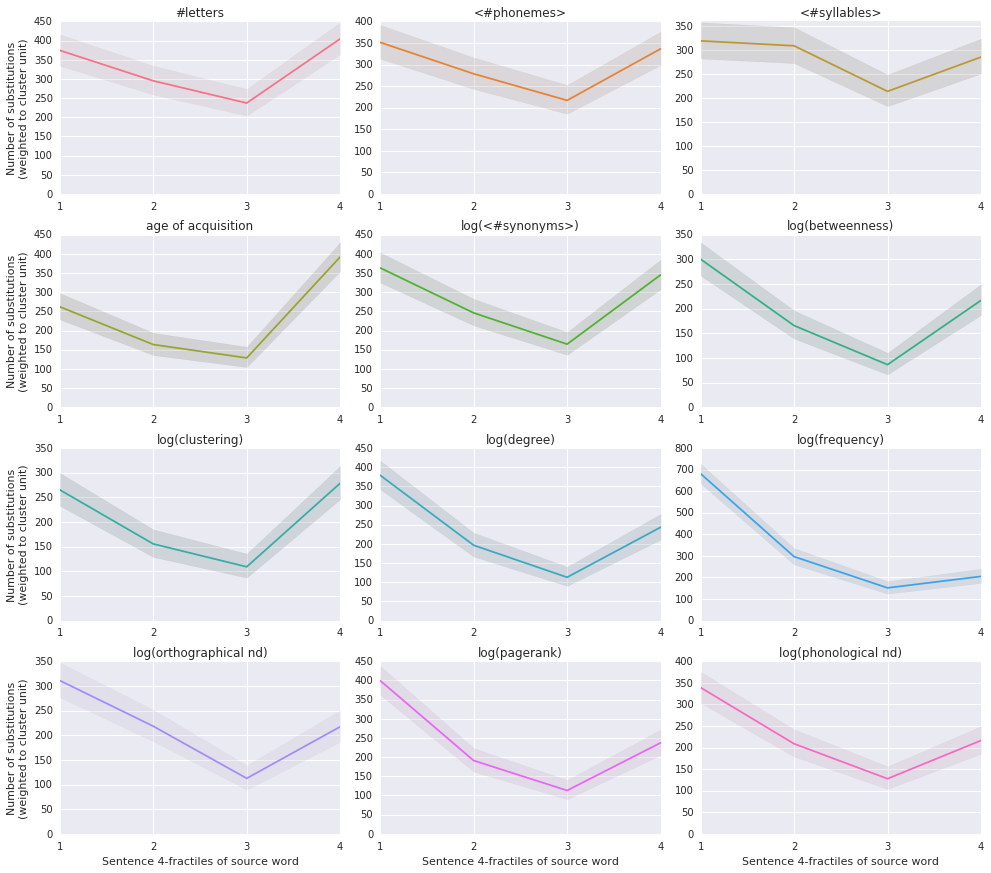

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

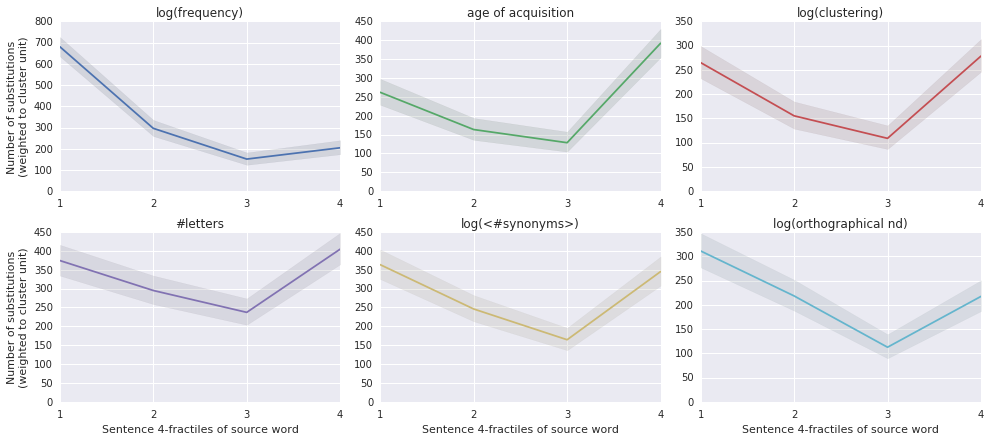

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)